In this notebook, we will be using machine learning to predict the probability of a pirate attack in certain places. We will use geopandas to visualize our data, and tensorflow to train our model.

Our dataset is taken from kaggle: [Global Maritime Pirate Attacks (1993–2020)](https://www.kaggle.com/datasets/n0n5ense/global-maritime-pirate-attacks-19932020).
We will also make use of [Open Street Map data for coastlines](https://osmdata.openstreetmap.de/data/coastlines.html).


Let's start by importing our libraries.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, losses
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.12.0


Now, we read in our data. We drop several columns regarding specifics of the attacks. We also drop data regarding shore lines since we will calculate those manually later. Finally, we load it into a geopandas dataframe.

Note: the raw data has the columns ordered differently. We rearrange them to make it easier to work with.
Note 2: we set our crs to EPSG:32618. This will be important soon.

In [3]:
attacks = pd.read_csv("pirate_attacks.csv")
attacks = attacks.drop(
    [
        "vessel_name",
        "vessel_status",
        "data_source",
        "attack_type",
        "date",
        "time",
        "location_description",
        "attack_description",
        "nearest_country",
        "eez_country",
        # we will calculate everything shore related with geopandas
        "shore_latitude",
        "shore_longitude",
        "shore_distance",
    ],
    axis=1,
)

# our longitude and latitude are switched!
attacks = attacks.rename(mapper={"longitude": "latitude", "latitude": "longitude"})

# reorder our columns
cols = attacks.columns.tolist()
cols.reverse()
attacks = attacks[cols]

attacks = gpd.GeoDataFrame(
    attacks,
    # by convention, we say latitude first. gpd expects longitude first.
    geometry=gpd.points_from_xy(attacks.longitude, attacks.latitude),
    # set our coordinate system
    crs="EPSG:32618",
)
attacks.head()

,vessel_type,latitude,longitude,geometry
0,NaN,19.700000,116.9667,POINT (116.967 19.700)
1,NaN,22.350000,116.0000,POINT (116.000 22.350)
2,NaN,19.670000,115.2500,POINT (115.250 19.670)
3,NaN,29.900000,124.5833,POINT (124.583 29.900)
4,NaN,18.133333,120.2667,POINT (120.267 18.133)


Let's plot the points to see what we're working with.

<Axes: >

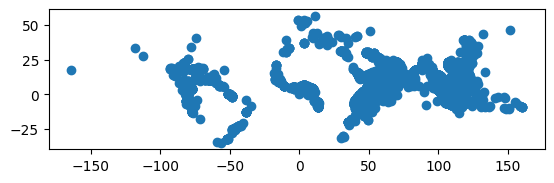

In [4]:
attacks.plot()

These points don't mean much right now. We need to overlay them onto a map of the world to get an understanding of where each one is. To do this, let's load in the coastlines.

Note: The coastline data is very large, so it can take some time to load when we are working with the dataframe.

In [5]:
coastlines = gpd.read_file("coastlines/lines.shp")

And now we can overlay our attacks onto the coastlines.

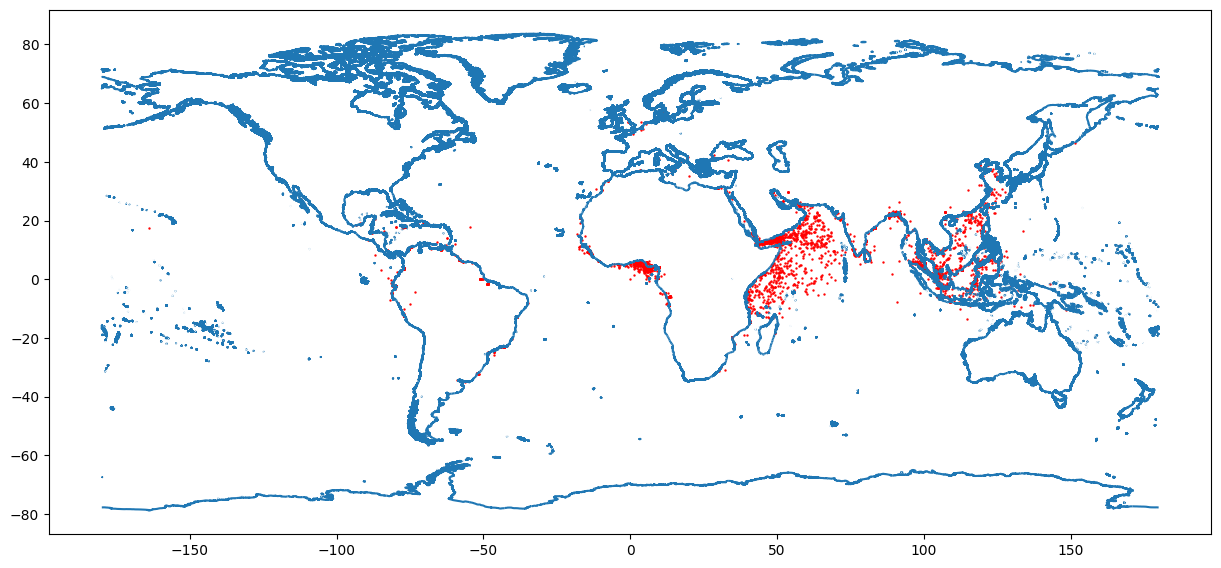

In [6]:
_, ax = plt.subplots(figsize=(15, 15))
coastlines.plot(ax=ax)
attacks.plot(ax=ax, color="red", markersize=0.5)
plt.show()

Now that we have our visualization, our next step is going to be to recalculate the distance column we removed. To do this, our data must use the same coordinate system. Let's check the coordinate system of each dataframe.

In [7]:
attacks.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
coastlines.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We created our attacks dataframe using the WGS 84 / UTM zone 18N coordinate system, which is a projected coordinate system using meters. Meanwhile, our coastlines makes use of the WGS 84 coordinate system, which is a geographic coordinate system using degrees. We need to convert our coastlines to match our attacks, so we can calculate distance in meters. We can do this with the [`geopandas.GeoDataFrame.to_crs`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) function.

Note: we still keep our original coastlines dataframe, since we will need it later when we want to plot stuff

In [9]:
coastlines_projected = coastlines.to_crs("EPSG:32618")

Now that both dataframes are using the same CRS, we are good to go! We can make use of the [`geopandas.GeoDataFrame.sjoin_nearest`](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin_nearest.html) function to calculate distance accurately.

In [10]:
attacks = attacks.sjoin_nearest(
    coastlines_projected, how="left", distance_col="coast_distance"
)
attacks = attacks.drop(["index_right", "FID"], axis=1)
attacks.head()

,vessel_type,latitude,longitude,geometry,coast_distance
0,NaN,19.700000,116.9667,POINT (116.967 19.700),35823.583724
1,NaN,22.350000,116.0000,POINT (116.000 22.350),35824.550417
2,NaN,19.670000,115.2500,POINT (115.250 19.670),35825.300424
3,NaN,29.900000,124.5833,POINT (124.583 29.900),35815.967096
4,NaN,18.133333,120.2667,POINT (120.267 18.133),35820.283728


Something is off right now: our dataset is only positive results! We need to add in negative results so that our model can train on those. First, lets add in a column for our target variable `attack`.

In [11]:
attacks["attack"] = 1
attacks.head()

,vessel_type,latitude,longitude,geometry,coast_distance,attack
0,NaN,19.700000,116.9667,POINT (116.967 19.700),35823.583724,1
1,NaN,22.350000,116.0000,POINT (116.000 22.350),35824.550417,1
2,NaN,19.670000,115.2500,POINT (115.250 19.670),35825.300424,1
3,NaN,29.900000,124.5833,POINT (124.583 29.900),35815.967096,1
4,NaN,18.133333,120.2667,POINT (120.267 18.133),35820.283728,1


Our dataset has ~7,500 positive results. Let's create a new dataframe roughly double the size with random latitudes and longitudes. This will make ~1/3 of the data positive, and ~2/3 negative.

In [12]:
minX, minY, maxX, maxY = attacks.total_bounds
random_points = pd.DataFrame()
random_points["vessel_type"] = np.random.choice(
    attacks.vessel_type.values.tolist(), size=7500 * 2
)
random_points["latitude"] = np.random.randint(minY - 10, maxY + 10, size=7500 * 2)
random_points["longitude"] = np.random.randint(minX - 10, maxX + 10, size=7500 * 2)
random_points["attack"] = 0
random_points = gpd.GeoDataFrame(
    random_points,
    geometry=gpd.points_from_xy(random_points.longitude, random_points.latitude),
    crs="EPSG:32618",
)
random_points.head()

,vessel_type,latitude,longitude,attack,geometry
0,nan,31,27,0,POINT (27.000 31.000)
1,nan,-31,-120,0,POINT (-120.000 -31.000)
2,nan,62,-77,0,POINT (-77.000 62.000)
3,nan,-10,20,0,POINT (20.000 -10.000)
4,nan,30,93,0,POINT (93.000 30.000)


Let's take a look at the random points.

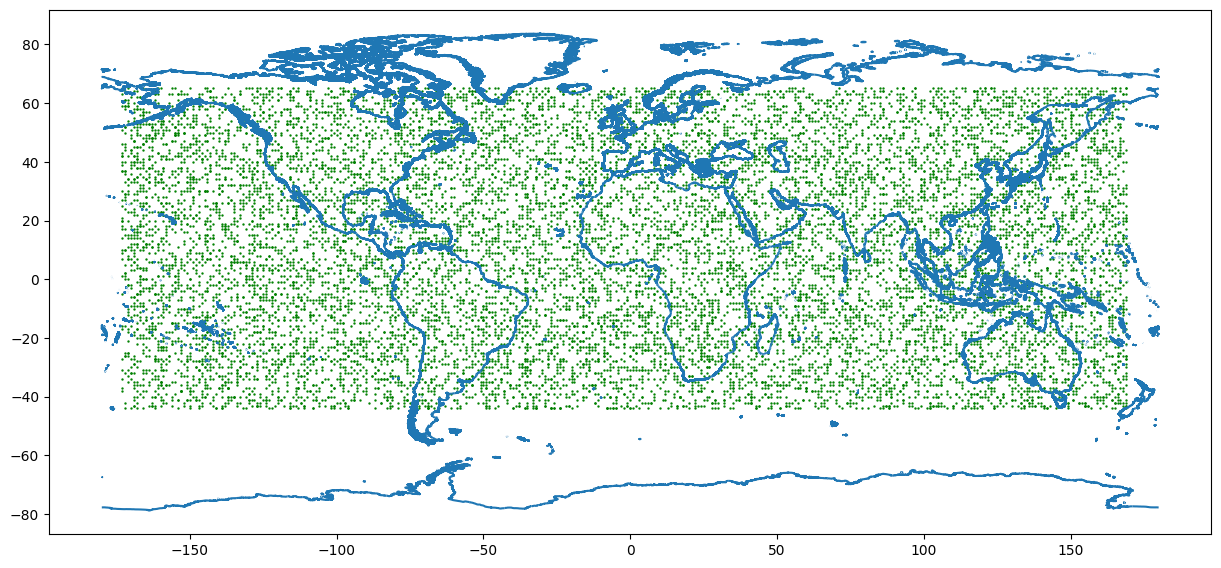

In [13]:
_, ax = plt.subplots(figsize=(15, 15))
coastlines.plot(ax=ax)
random_points.plot(ax=ax, color="green", markersize=0.5)
plt.show()

Be sure to calculate coast distance just like before.

In [14]:
random_points = random_points.sjoin_nearest(
    coastlines_projected, how="left", distance_col="coast_distance"
)
random_points = random_points.drop(["index_right", "FID"], axis=1)
random_points.head()

,vessel_type,latitude,longitude,attack,geometry,coast_distance
0,nan,31,27,0,POINT (27.000 31.000),35913.550393
1,nan,-31,-120,0,POINT (-120.000 -31.000),36060.550563
2,nan,62,-77,0,POINT (-77.000 62.000),36017.550307
3,nan,-10,20,0,POINT (20.000 -10.000),35920.550505
4,nan,30,93,0,POINT (93.000 30.000),35847.550395


And now we can merge the two dataframes together.

In [15]:
data = pd.concat([attacks, random_points], ignore_index=True)
data.head()

,vessel_type,latitude,longitude,geometry,coast_distance,attack
0,NaN,19.700000,116.9667,POINT (116.967 19.700),35823.583724,1
1,NaN,22.350000,116.0000,POINT (116.000 22.350),35824.550417,1
2,NaN,19.670000,115.2500,POINT (115.250 19.670),35825.300424,1
3,NaN,29.900000,124.5833,POINT (124.583 29.900),35815.967096,1
4,NaN,18.133333,120.2667,POINT (120.267 18.133),35820.283728,1


One last thing we need to do is convert our vessel types into numbers. There's more advanced ways of doing this, but for now we will just map each vessel type with a dictionary.

In [16]:
vessel_mappings = {
    vessel_type: idx for idx, vessel_type in enumerate(data["vessel_type"].unique())
}
vessel_mappings

{nan: 0,
 'Chemical Tanker': 1,
 'Tug and Barge': 2,
 'General Cargo': 3,
 'LPG Tanker': 4,
 'Product Tanker': 5,
 'Bulk Carrier': 6,
 'Offshore Supply Ship': 7,
 'Vehicle Carrier': 8,
 'Crude Tanker': 9,
 'Fishing Vessel': 10,
 'Other': 11,
 'Container': 12,
 'Refrigerated Cargo': 13,
 'Pipe Lay Barge': 14,
 'Tug': 15,
 'Floating Production Storage and Offloading': 16,
 'Offshore Tug': 17,
 'Wood Chips Carrier': 18,
 'Bunkering Tanker': 19,
 'Hopper Dredger': 20,
 'Yacht': 21,
 'Floating Storage and Offloading': 22,
 'Passenger Ship': 23,
 'Offshore Support Vessel': 24,
 'Cable Ship': 25,
 'Ore Carrier': 26,
 'LNG Tanker': 27,
 'Crude Oil Tanker': 28,
 'Pipe Layer': 29,
 'Offshore Supply': 30,
 'Research Vessel': 31,
 'Dredger': 32,
 'Heavy Load Carrier': 33,
 'Asphalt/Bitumen Tanker': 34,
 'Supply Vessel': 35,
 'Dhow': 36,
 'Cement Carrier': 37,
 'Offshore Supply ship': 38,
 'OFFSHORE SUPPLY SHIP': 39,
 'Tanker': 40,
 'CONTAINER': 41,
 'BULK CARRIER': 42,
 'Tug / Barge': 43,
 'PRODUC

In [17]:
data["vessel_type"] = data["vessel_type"].map(vessel_mappings)
data.head()

,vessel_type,latitude,longitude,geometry,coast_distance,attack
0,0,19.700000,116.9667,POINT (116.967 19.700),35823.583724,1
1,0,22.350000,116.0000,POINT (116.000 22.350),35824.550417,1
2,0,19.670000,115.2500,POINT (115.250 19.670),35825.300424,1
3,0,29.900000,124.5833,POINT (124.583 29.900),35815.967096,1
4,0,18.133333,120.2667,POINT (120.267 18.133),35820.283728,1


Now let's prepare our data for training. We need to split our data into training and testing sets, and then we can train our model.

In [18]:
X = data.drop(["attack", "geometry"], axis=1)
y = data.attack
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

You can run this cell to reset your model if you want to try different things.

In [19]:
tf.keras.backend.clear_session()

Now we can create our model. We will use a simple neural network with 2 hidden layers. Our output layer will be a single neuron with a sigmoid activation function since we have a binary problem.

In [20]:
model = tf.keras.Sequential(
    [
        layers.InputLayer(input_shape=(4,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


Now we can compile and train our model. We will use the Adam optimizer and the binary cross-entropy loss function. We will also track binary accuracy as a metric.

In [21]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0),
)

We will train our model for 20 epochs, and use 10% of our training data as validation data.

Note: you can play around with the number of epochs and the validation split to see how it affects the model.

In [22]:
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_split=0.1,
)

Epoch 1/20
507/507 [==============================] - 2s 2ms/step - loss: 52.0836 - binary_accuracy: 0.4618 - val_loss: 2.2706 - val_binary_accuracy: 0.3343
Epoch 2/20
507/507 [==============================] - 1s 2ms/step - loss: 9.2736 - binary_accuracy: 0.4352 - val_loss: 11.6435 - val_binary_accuracy: 0.3343
Epoch 3/20
507/507 [==============================] - 1s 2ms/step - loss: 10.2106 - binary_accuracy: 0.5605 - val_loss: 3.5501 - val_binary_accuracy: 0.8584
Epoch 4/20
507/507 [==============================] - 1s 2ms/step - loss: 12.4366 - binary_accuracy: 0.6558 - val_loss: 2.0908 - val_binary_accuracy: 0.7662
Epoch 5/20
507/507 [==============================] - 1s 2ms/step - loss: 10.1381 - binary_accuracy: 0.7336 - val_loss: 1.9857 - val_binary_accuracy: 0.9006
Epoch 6/20
507/507 [==============================] - 1s 2ms/step - loss: 5.1805 - binary_accuracy: 0.8037 - val_loss: 8.9185 - val_binary_accuracy: 0.4503
Epoch 7/20
507/507 [==============================] - 1s 2m

With our model trained, let's plot the loss and accuracy over time. If the validation loss and accuracy are much worse than the training loss and accuracy, then we are overfitting. We can use the graph to determine when this happens and stop training then.

If we see a drop in accuracy or a rise in loss, after some time, we should also stop training then.

Note: try training for more epochs and see why we chose 20 epochs

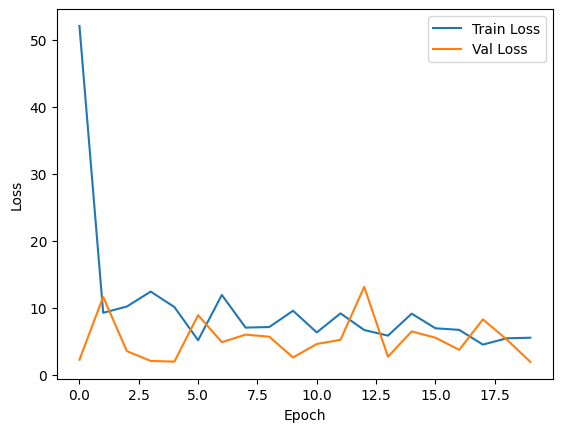

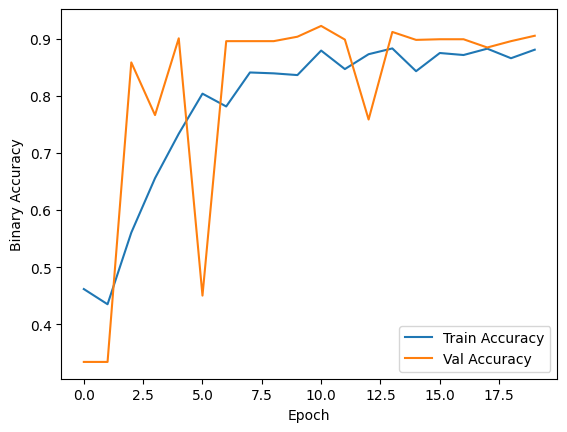

In [23]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(hist["epoch"], hist["loss"], label="Train Loss")
plt.plot(hist["epoch"], hist["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Binary Accuracy")
plt.plot(hist["epoch"], hist["binary_accuracy"], label="Train Accuracy")
plt.plot(hist["epoch"], hist["val_binary_accuracy"], label="Val Accuracy")
plt.legend()
plt.show()

Now that we have trained our model, let's see how it performs on the test set.

In [24]:
_, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 1)}%")

141/141 [==============================] - 0s 2ms/step - loss: 2.1958 - binary_accuracy: 0.9061
Test accuracy: 90.6%


Let's see where our model thinks the most likely attacks are.

In [25]:
predictions = X_test.copy()
predictions["predicted"] = model.predict_on_batch(predictions)
predictions["predicted"] = predictions["predicted"].apply(
    lambda x: 1 if x >= 0.5 else 0
)
predictions.sort_values(by="predicted", ascending=False)

,vessel_type,latitude,longitude,coast_distance,predicted
481,0,-0.540167,117.1383,35823.412179,1
4348,0,12.533100,47.9223,35892.628144,1
16108,6,-7.000000,64.0000,35876.550497,1
709,0,6.950000,79.8432,35860.707259,1
2017,0,21.878333,88.0717,35852.478718,1
...,...,...,...,...,...
22030,55,10.000000,-140.0000,36080.550450,0
12750,55,14.000000,134.0000,35806.550439,0
18372,55,24.000000,116.0000,35824.550412,0
18566,55,36.000000,-70.0000,36010.550379,0


Let's add in our actual values so we can see which ones our model got right.

In [26]:
predictions["actual"] = y_test
predictions

,vessel_type,latitude,longitude,coast_distance,predicted,actual
481,0,-0.540167,117.138300,35823.412179,1,1
15597,55,-17.000000,150.000000,35790.550525,0,0
7694,55,34.000000,95.000000,35845.550384,0,0
13781,55,65.000000,13.000000,35927.550299,0,0
7461,12,-12.019722,-77.206944,36017.757455,0,1
...,...,...,...,...,...,...
2934,0,4.853333,98.325000,35842.225465,1,1
18130,55,18.000000,100.000000,35840.550428,0,0
2960,0,-1.350000,116.966700,35823.583782,1,1
11293,55,52.000000,-72.000000,36012.550335,0,0


We can plot the predictions on a map. Here we make 3 plots: one for the actual values, one for the predicted values, and one to see which ones our model got right.

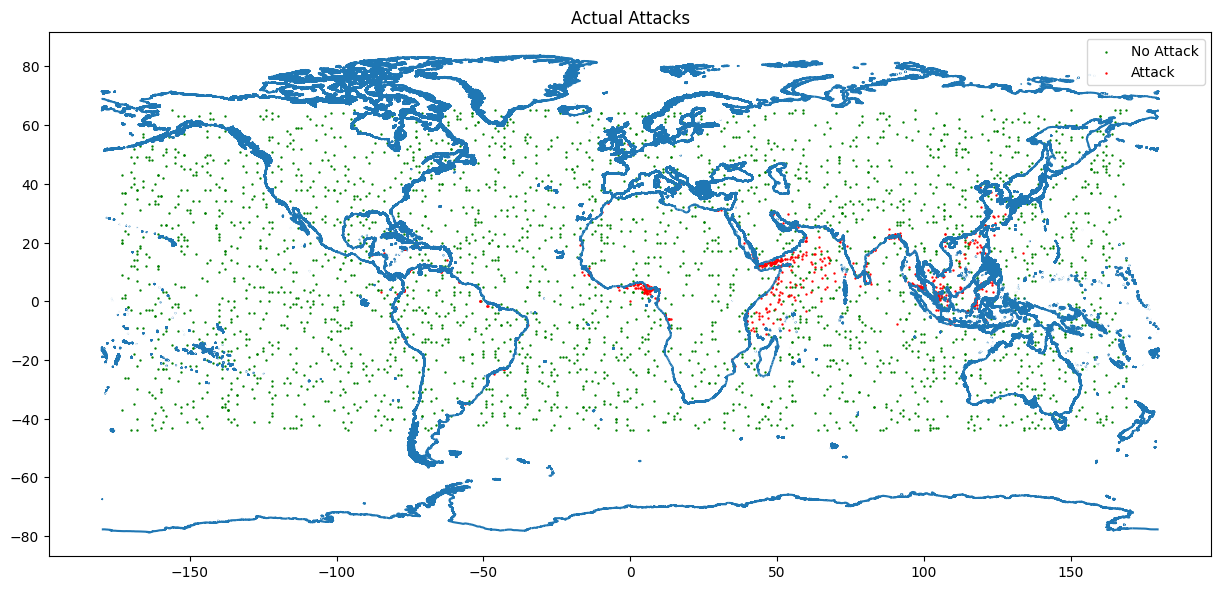

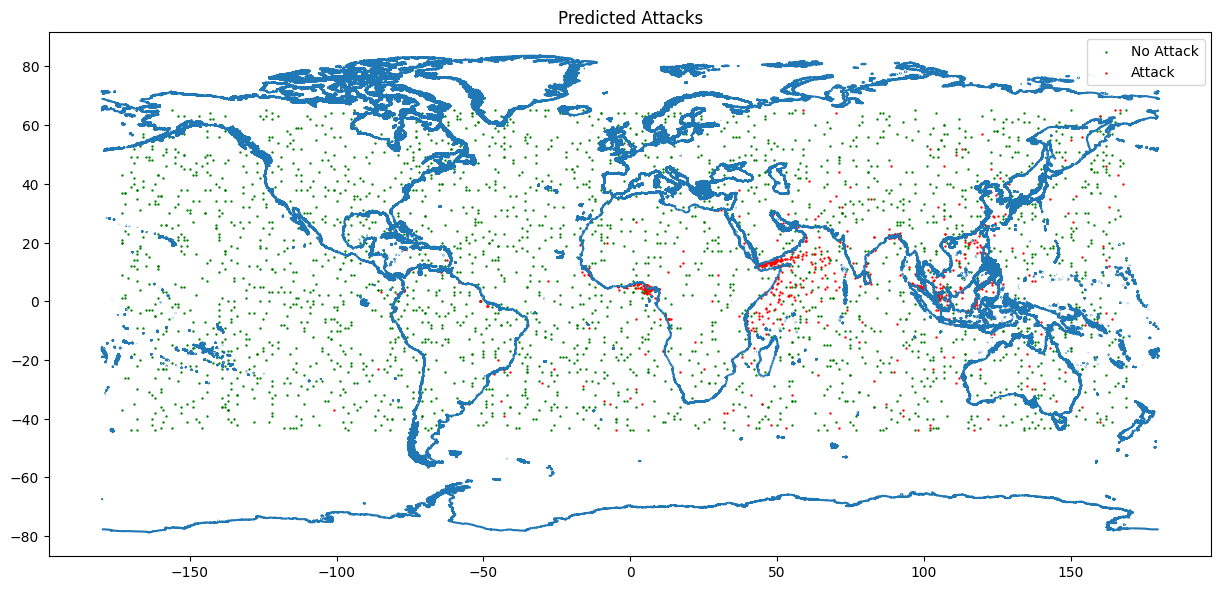

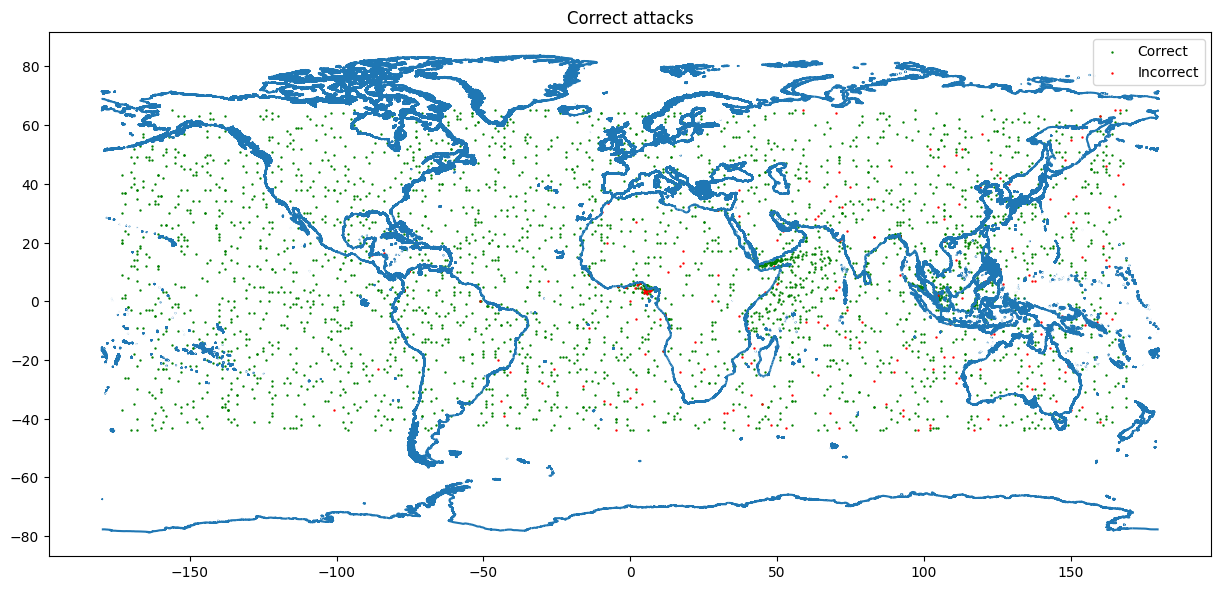

In [27]:
predictions = gpd.GeoDataFrame(
    predictions,
    geometry=gpd.points_from_xy(predictions.longitude, predictions.latitude),
    crs="EPSG:32618",
)

# actual values
_, ax = plt.subplots(figsize=(15, 15))
coastlines.plot(ax=ax)
predictions.loc[predictions["actual"] == 0].plot(
    ax=ax, color="green", markersize=0.5, label="No Attack"
)
predictions.loc[predictions["actual"] == 1].plot(
    ax=ax, color="red", markersize=0.5, label="Attack"
)
ax.title.set_text("Actual Attacks")
plt.legend()
plt.show()

# predicted values
_, ax = plt.subplots(figsize=(15, 15))
coastlines.plot(ax=ax)
predictions.loc[predictions["predicted"] == 0].plot(
    ax=ax, color="green", markersize=0.5, label="No Attack"
)
predictions.loc[predictions["predicted"] == 1].plot(
    ax=ax, color="red", markersize=0.5, label="Attack"
)
ax.title.set_text("Predicted Attacks")
plt.legend()
plt.show()

# model accuracy
_, ax = plt.subplots(figsize=(15, 15))
coastlines.plot(ax=ax)
predictions.loc[predictions["actual"] == predictions["predicted"]].plot(
    ax=ax, color="green", markersize=0.5, label="Correct"
)
predictions.loc[predictions["actual"] != predictions["predicted"]].plot(
    ax=ax, color="red", markersize=0.5, label="Incorrect"
)
ax.title.set_text("Correct attacks")
plt.legend()
plt.show()

We can see that the model predicts correctly in high volume areas such as the Gulf of Guinea, the Gulf of Aden, and in the East Indian Ocean. However, it seems to guess randomly elsewhere.

One hypothesis as to why could be that the model still has not learned where actual land masses are; negative points inside of land masses still have large distance to coast values because of how they were calculated. In the future, this could possibly be fixed by assigning a 0 or negative value to points within land masses.

This model could also be improved by taking into account the columns we dropped earlier. The current model only uses coordinates, distance to coast, and ship type when predicted. Making use of data such as the country the ship was in could prove fruitful in improving the model.

Overall, the model performs well with an accuracy of almost 90%, but could be improved in the future.